In [1]:
using Pkg
using Markdown, Revise
using NDTools, Plots, View5D, ImageShow
using PSFs

┌ Info: Precompiling PSFs [e8810a93-244e-46c5-8da3-35c5dd956001]
└ @ Base loading.jl:1423


In [47]:
function show_xyz(args...)
    dat = []
    for data in args
        gamma= (eltype(data) <: Complex) ? 0.6 : 0.3
        space = zeros(size(data,2), 10) .+ 0.12
        if ndims(data) == 4 
            xy = data[:,:, size(data,3)÷2+1,:]
            xy_disp = (abs.(xy) ./ maximum(abs.(xy))) .^ gamma
            xz = data[:,size(data,2)÷2+1,:,:]
            xz_disp = (abs.(xz) ./ maximum(abs.(xz))) .^ gamma
            push!(dat, cat((xy_disp[:,:,1])',space, (xy_disp[:,:,2])',space, (xy_disp[:,:,3])', space,space,(xz_disp[:,:,1])',space, (xz_disp[:,:,2])',space, (xz_disp[:,:,3])', dims=2))
        else
            xy = data[:,:,size(data,3)÷2+1]
            xy_disp = (abs.(xy) ./ maximum(abs.(xy))) .^ gamma
            xz = data[:,size(data,2)÷2+1,:]
            xz_disp = (abs.(xz) ./ maximum(abs.(xz))) .^ gamma
            push!(dat, cat(xy_disp',space, xz_disp',dims=2))
        end
    end
    return Gray.(cat(dat...,dims=1))
end

show_xyz (generic function with 1 method)

# Simulate a first simple PSF

- prepare the required parameters
- simulate the widefield PSF
- display the result

## required parameters. Wavelength, NA, n

In [72]:
λ_em = 0.5; NA = 1.4; n = 1.52
λ_ex = 0.488 # only needed for some PSFs, such as confocal, ISM or TwoPhoton
pp = PSFParams(λ_em, NA, n)
sz = (128, 128, 128)
sampling = (0.050,0.050,0.050)
print(pp)

PSFParams(0.5, 1.4, 1.52, Float32, ModeWidefield, PSFs.pol_circ, PSFs.var"#3#4"(), MethodRichardsWolf, nothing, Aberrations(Any[], Any[], :OSA), nothing, nothing, nothing)

## Simulate Widefield PSF

In [32]:
p = psf(sz, pp; sampling=sampling);

# Display Data

In [8]:
size(p)

(128, 128, 128)

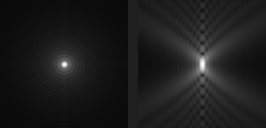

In [48]:
show_xyz(p)


## Vector Amplitudes

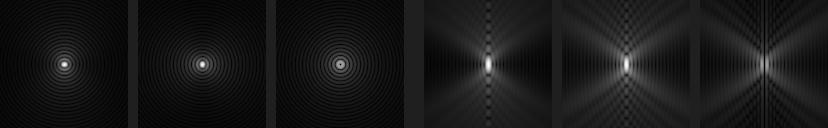

In [57]:
pp = PSFParams(0.5, 1.4, 1.52; pol=pol_circ)
pa = apsf(sz, pp; sampling=sampling)
show_xyz(pa)

# Influence of the Field Vectors on Dipole PSFs  

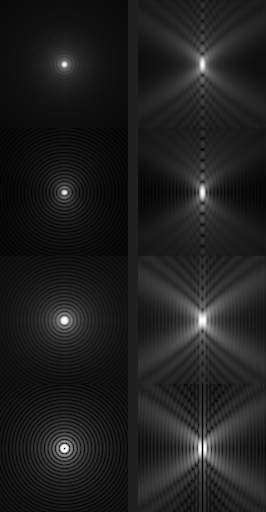

In [60]:
pp1 = PSFParams(pp; transition_dipole=(1.0, 0.0, 0.0)); p1 = psf(sz, pp1; sampling=sampling);
pp2 = PSFParams(pp; transition_dipole=(0.0, 0.5, 1.0)); p2 = psf(sz, pp2; sampling=sampling);
pp3 = PSFParams(pp; transition_dipole=(0.0, 0.0, 1.0)); p3 = psf(sz, pp3; sampling=sampling);
show_xyz(p,p1,p2,p3)

# Calculation methods

  0.423900 seconds (14.74 k allocations: 555.147 MiB, 21.74% gc time)
  0.256877 seconds (45.66 k allocations: 479.081 MiB)
  0.712803 seconds (121.79 k allocations: 601.072 MiB, 52.14% gc time)
  0.613060 seconds (121.79 k allocations: 601.072 MiB, 44.19% gc time)
  0.323566 seconds (121.79 k allocations: 601.072 MiB)


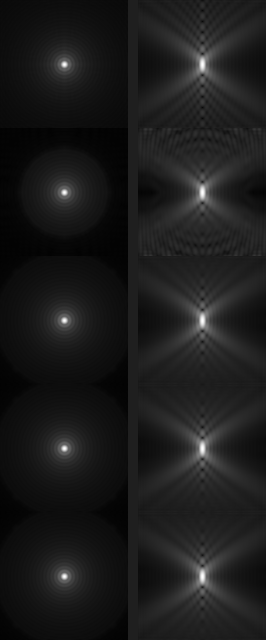

In [83]:
pp1 = PSFParams(λ_em, NA, n; method=MethodRichardsWolf); @time p_RW = psf(sz, pp1; sampling=sampling);
pp2 = PSFParams(λ_em, NA, n; method=MethodPropagate); @time p_slice = psf(sz, pp2; sampling=sampling);
pp3 = PSFParams(λ_em, NA, n; method=MethodPropagateIterative); @time p_iter = psf(sz, pp3; sampling=sampling);
pp4 = PSFParams(λ_em, NA, n; method=MethodShell); @time p_shell = psf(sz, pp3; sampling=sampling);
pp5 = PSFParams(λ_em, NA, n; method=MethodSincR); @time p_sincr = psf(sz, pp3; sampling=sampling);
show_xyz(p_RW,p_slice,p_iter,p_shell, p_sincr)

# Various Microscopy Modes

  0.428692 seconds (14.75 k allocations: 555.148 MiB, 17.66% gc time)
  0.356919 seconds (14.24 k allocations: 555.135 MiB)
  0.523858 seconds (1.25 M allocations: 521.890 MiB, 17.20% gc time, 52.90% compilation time)
  1.121284 seconds (233.55 k allocations: 2.356 GiB, 13.56% gc time, 6.40% compilation time)
  0.398352 seconds (14.25 k allocations: 571.136 MiB, 12.44% gc time)


┌ Warning: Your calculation is undersampled along XY by factors of (1.1337705f0, 1.1337705f0). The PSF calculation will be incorrect.)
└ @ PSFs C:\Users\pi96doc\Nextcloud-Uni\Julia\PSFs.jl\src\util.jl:427
┌ Warning: Your calculation is undersampled along XY by factors of (1.1337705f0, 1.1337705f0). The PSF calculation will be incorrect.)
└ @ PSFs C:\Users\pi96doc\Nextcloud-Uni\Julia\PSFs.jl\src\util.jl:427


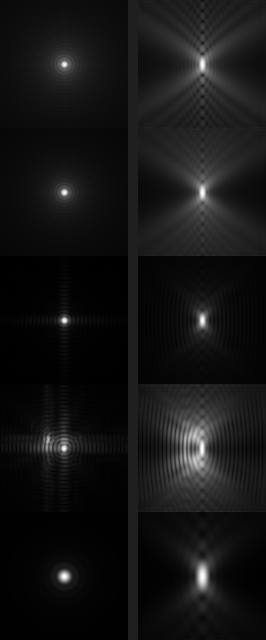

In [95]:
pp_em = PSFParams(λ_em, NA, n; mode=ModeWidefield); @time p_wf = psf(sz, pp_em; sampling=sampling);
pp_ex = PSFParams(λ_ex, NA, n; mode=ModeWidefield, aplanatic=aplanatic_illumination); @time p_wf_ex = psf(sz, pp_ex; sampling=sampling);

pinhole=1.0 # in Airy Units
pp2 = PSFParams(λ_em, NA, n; mode=ModeConfocal); 
@time p_conf = psf(sz, pp2; pp_ex=pp_ex, pinhole=pinhole, sampling=sampling);
pp3 = PSFParams(λ_em, NA, n; mode=ModeISM); @time p_ism = psf(sz, pp3; pp_ex=pp_ex, sampling=sampling);
pp4 = PSFParams(λ_ex * 2, NA, n; mode=Mode2Photon, aplanatic=aplanatic_illumination); 
@time p_2p = psf(sz, pp4; sampling=sampling);

show_xyz(p_wf, p_wf_ex, p_conf, p_ism[1], p_2p)

In [97]:
@show eltype(p_wf)
@show eltype(p_wf_ex)
@show eltype(p_conf)
@show eltype(p_ism[1])
@show eltype(p_2p)


eltype(p_wf) = Float64
eltype(p_wf_ex) = Float64
eltype(p_conf) = Float64
eltype(p_ism[1]) = Float64
eltype(p_2p) = Float64


Float64

In [94]:
size(p_ism)

(128, 128, 128)